For discriminating between SE and other pulses, CH6 in Brian Lenardo's thesis has a fairly clear example
using the prompt fraction and pulse area in the first 500ns. In XeNu data this is usually `fparameter[6]`. 

Time values corresponding to the `fparameters` are found in the config files, which are stored as
a `TMacro` in the processed ROOT file.

In [1]:
import uproot
import awkward as ak
import hist
from hist import Hist
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib_inline
from matplotlib.patches import Ellipse

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
plt.style.use("../assets/SetLZStyle.mplstyle")

In [2]:
f1_path = "/home/emiz/projects/projectdata/XeNu/Run12_circ_sweep_getse/tmp_Run12_2725_20210720_12kVE13kVC0A_Top680_780_680_780VBot990V_Top3Fold_1200sccm_BgWPbShield.root"
pulse_data = uproot.open(f1_path)["pulse_data"].arrays()

# Need to be explicit about length of parameter vectors so we can select first or second fparameter, etc.
pulse_data["fparameters"] = ak.pad_none(pulse_data.fparameters, 8, clip=True)
pulse_data["tparameters"] = ak.pad_none(pulse_data.tparameters, 8, clip=True)
pulse_data = pulse_data[pulse_data.channel_id == -2]

In [3]:
npe = hist.axis.Regular(
    500,
    1,
    1e6,
    name="npe",
    label="Pulse Area [npe]",
    transform=hist.axis.transform.log,
)
pa = hist.axis.Regular(
    500,
    1,
    10000,
    name="pa",
    label="Peak Amplitude [arb]",
    transform=hist.axis.transform.log,
)
pf = hist.axis.Regular(500, 0, 1, name="pf", label="Prompt Fraction")
aft = hist.axis.Regular(500, 0, 2, name="aft", label="Area Fraction Time")

## Prompt Fraction

In [4]:
h = (Hist(npe, pf)).fill_flattened(
    npe=pulse_data.npe,
    pf=pulse_data.fparameters[:, 6],
)
pf.label = "Prompt Fraction: 500ns"

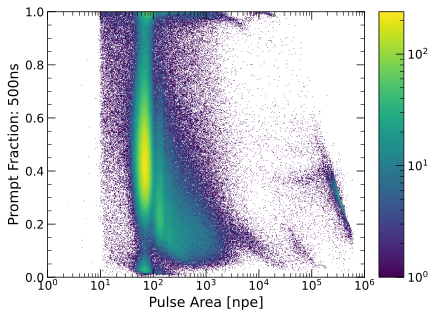

In [5]:
fig, ax = plt.subplots()
ax.set(xscale="log")
artists = h.project("npe", "pf").plot(ax=ax, norm=LogNorm(), flow=None)
artists[0].set_rasterized(True)  # Don't try to make svg of so many bins

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f35c7f7fe10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

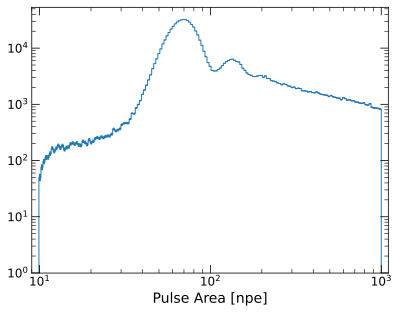

In [6]:
fig, ax = plt.subplots()
ax.set(xscale="log", yscale="log", xlim=(0.9e1, 1.1e3))
h[{"pf": slice(0.1j, 0.8j, sum), "npe": slice(1e1j, 1e3j, None)}].project("npe").plot(
    ax=ax, flow=None
)

Try looking at peak amplitude vs area (or width) for selecting progenitors?

Cut out S1s with prompt fraction cut

In [7]:
h = (Hist(npe, pa, pf)).fill_flattened(
    npe=pulse_data.npe,
    pf=pulse_data.fparameters[:, 6],
    pa=pulse_data.peak_amplitude,
)

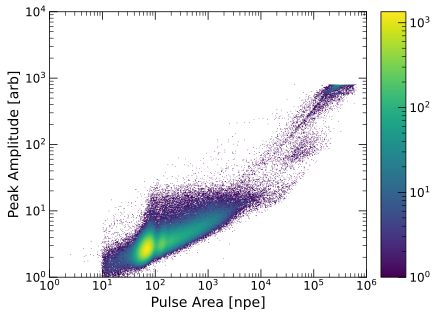

In [8]:
fig, ax = plt.subplots()
ax.set(yscale="log", xscale="log")
artists = (
    h[{"pf": slice(0j, 0.8j, sum)}]
    .project("npe", "pa")
    .plot(ax=ax, norm=LogNorm(), flow=None)
)
artists[0].set_rasterized(True)  # Don't try to make svg of so many bins

## Area Fraction Time (AFT)

AFT 75-25 or similar also works for rejecting S1s

In [9]:
npe = hist.axis.Regular(
    500,
    1e1,
    1e3,
    name="npe",
    label="Pulse Area [npe]",
    transform=hist.axis.transform.log,
)

h = Hist(npe, aft, pf).fill_flattened(
    npe=pulse_data.npe,
    pf=pulse_data.fparameters[:, 6],
    aft=(pulse_data.tparameters[:, 4] - pulse_data.tparameters[:, 2]),
)
aft.label = "AFT 75-25 [$\mu$s]"

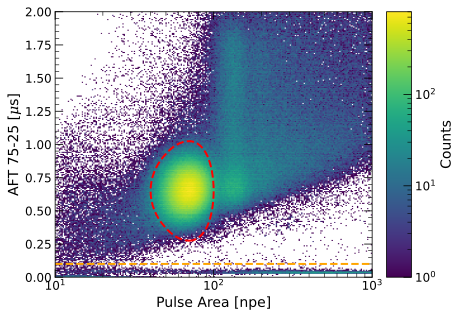

In [11]:
# | label: aft-pulse-area

fig, ax = plt.subplots()
ax.set(xscale="log")
artists = (
    h[
        {
            "pf": slice(0j, 1j, sum),
            "npe": slice(1e1j, 1e3j, 2j),
            "aft": slice(None, None, 2j),
        }
    ]
    .project("npe", "aft")
    .plot(ax=ax, norm=LogNorm(), flow=None)
)
fig.axes[1].set(ylabel="Counts")

fig.axes[0].add_patch(
    Ellipse(
        xy=(7e1, 0.65),
        width=60,
        height=0.75,
        edgecolor="red",
        facecolor="none",
        linewidth=2,
        linestyle="--",
    )
)

ax.axhline(y=0.1, color="orange", linewidth=2, linestyle="--")

artists[0].set_rasterized(True)  # Don't try to make svg of so many bins